In [1]:
# Code to preprocessing outcome data, imaging features, then create predictions based on the features
# outputs include: predicted models, accuracies, feature importance, table 1 basic distributions with outcome
# Setup, imports
import math
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
from tableone import TableOne
from IPython.display import HTML

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn import preprocessing, decomposition, svm
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score,  ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import auc 
from sklearn.metrics import RocCurveDisplay

import catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 106)

# Helper functions

In [2]:
#feature selection
#dropping high VIF columns
def calculate_vif(X, thresh=15):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

def VIF_feature_select(data, name, id_col_name = 'filename', feature_select = 1):
    
    #if there is a filename column, we will remove it and add it back later.
    #if no filename column, ignore
    imNameFlag = 0
    if id_col_name in data.columns:
        dataTemp = data
        data = data.drop(columns=[id_col_name])
        imNameFlag = 1
        
    csvName = 'dataFiltered_' + name + '.csv'
    
    if(os.path.isfile(csvName)):
        dataFiltered = pd.read_csv(csvName)
        return dataFiltered
    else:
        if (feature_select == 0):
            return data

        dataFiltered = calculate_vif(data, 10)
        
        if (imNameFlag == 1):
            dataFiltered[id_col_name] = dataTemp[id_col_name]

        #saving feature selected data
        dataFiltered.to_csv(csvName, index = False)

        return dataFiltered

In [3]:
#data imports and preprocessing
data_radiomics_raw = pd.read_csv('radiomics_old.csv',engine='python')
data_outcomes_raw = pd.read_csv('segmentation_labels_mgfr_cls.csv',engine='python')

#joining both by ID, but have to edit the ID columns because they are labelled differently

data_outcomes_raw['filename'] = data_outcomes_raw['filename'].str.replace('.png', '', regex=False)
data_radiomics_raw['imName'] = data_radiomics_raw['imName'].str.split('_').str[:-1].str.join('_')

#removing useless columbs
data_radiomics_raw = data_radiomics_raw.drop('maskNum', axis=1)
data_outcomes_raw = data_outcomes_raw.drop_duplicates(subset = 'filename', keep = 'first')

# binary mapping of outcomes and file labels
data_outcomes_raw['mgfr_cls_flag'] = data_outcomes_raw['mgfr_cls'].map({'Normal': 0, 'Kidney_Disease': 1})
data_outcomes_raw['file_attributes_flag'] = data_outcomes_raw['file_attributes'].apply(
    lambda x: 0 if 'Normal' in x else (1 if 'Abnormal' in x else None)
)


data_outcomes_raw_filtered = data_outcomes_raw[['filename', 'file_attributes_flag', 'mgfr', 'mgfr_cls_flag']]
data_outcomes_raw_filtered

data_all = pd.merge(
    data_outcomes_raw_filtered,
    data_radiomics_raw,
    left_on='filename',
    right_on='imName',
    how='inner'  # use 'outer', 'left', or 'right' if needed
)

data_all = data_all.drop('imName', axis=1)
data_all.to_csv("data_cleaned.csv")
data_all

,filename,file_attributes_flag,mgfr,mgfr_cls_flag,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1__Still images_IM-0001-0020,0,201.050000,0,0.349595,1622.958220,1180.034745,107203.0,567.378098,4257.947761,...,1.095314,0.038393,6.942736,0.053655,776.825617,77.763435,0.000624,2.261034,0.000480,0.082289
1,1__Still images_IM-0001-0040,0,201.050000,0,0.417717,1905.351612,1404.624505,130856.5,795.898301,5198.174383,...,0.260777,0.040268,6.472604,0.068028,196.311433,529.590261,0.000316,0.445347,0.003166,0.002818
2,2__Still Images_IM-0001-0016,0,151.580000,0,0.346946,2116.748882,1583.480344,160310.5,734.396706,5086.256418,...,1.376564,0.029196,7.326310,0.043765,954.032463,86.649771,0.000504,1.850986,0.000492,0.062204
3,2__Still Images_IM-0001-0062,1,151.580000,0,0.473713,2323.803551,1779.031759,159973.0,1100.815160,5417.976331,...,0.506615,0.028774,7.345738,0.040238,846.827062,218.898343,0.000566,0.389957,0.001143,0.010082
4,3__still_images_5384_IM-0001-0031,0,40.830000,1,0.092461,1587.460963,1385.428814,129115.5,146.777456,3112.052957,...,0.328613,0.020899,7.227684,0.046129,536.441511,150.016135,0.000573,0.417694,0.001739,0.007096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,365a__Still_images_5346_IM-0002-0033,1,30.251345,1,0.484504,1478.479063,1019.656805,104768.5,716.328636,4424.487732,...,0.763487,0.019312,6.851189,0.073648,177.865458,117.500891,0.000471,1.020091,0.002587,0.008424
690,365a__Still_images_5346_IM-0002-0049,1,30.251345,1,0.422497,1592.250172,1176.384291,143944.5,672.720618,4502.239174,...,0.393930,0.038544,6.826292,0.063997,241.866607,380.024690,0.000327,0.354136,0.003597,0.001939
691,383a__Still_images_5375_IM-0001-0006,0,41.953214,1,0.524145,764.781866,558.649264,25410.5,400.856796,2461.336362,...,2.516635,0.076148,5.587849,0.164614,81.154095,62.247313,0.000966,3.585624,0.005910,0.032431
692,383b__Still_images_5379_IM-0001-0031,0,41.953214,1,0.534737,755.302919,561.381332,25080.0,403.888608,2494.182033,...,3.309076,0.063094,5.455190,0.175870,142.155549,43.245019,0.001396,5.264928,0.007239,0.071786


In [4]:
# basic stats
data_table1 = data_all.drop('filename', axis=1)
table1_columns = data_table1.columns.tolist()
table1_binary = TableOne(data_table1, columns=table1_columns, pval = True, 
                       groupby = ['mgfr_cls_flag'], htest_name=True, smd=True)
table1_binary

Grouped by mgfr_cls_flag                                                                                                                      
                                                                                 Missing                    Overall                          0                          1 P-Value               Test SMD (0,1)
n                                                                                                               694                        504                        190                                     
file_attributes_flag, n (%)                                   0                        0                 545 (78.5)                 437 (86.7)                 108 (56.8)  <0.001        Chi-squared     0.703
                                                              1                                          149 (21.5)                  67 (13.3)                  82 (43.2)                                     
mgfr, mean (SD)                                                                        0               120.2 (49.3)               141.4 (39.2)                63.8 (20.7)  <0.001  Two Sample T-test    -2.479
original_shape2D_Elongation, mean (SD)                                                 0                  0.4 (0.1)                  0.4 (0.1)                  0.4 (0.1)   0.061  Two Sample T-test    -0.163
original_shape2D_MajorAxisLength, mean (SD)                                            0             1610.8 (685.5)             1672.9 (670.7)             1446.1 (698.7)  <0.001  Two Sample T-test    -0.331
original_shape2D_MaximumDiameter, mean (SD)                                            0             1189.9 (505.1)             1236.7 (493.3)             1066.0 (516.2)  <0.001  Two Sample T-test    -0.338
original_shape2D_MeshSurface, mean (SD)                                                0         117288.8 (81163.5)         124602.5 (81119.3)          97888.2 (78233.3)  <0.001  Two Sample T-test    -0.335
original_shape2D_MinorAxisLength, mean (SD)                                            0              690.6 (322.5)              722.1 (319.1)              606.9 (317.1)  <0.001  Two Sample T-test    -0.362
original_shape2D_Perimeter, mean (SD)                                                  0            4701.7 (2075.1)            4901.5 (2028.6)            4171.8 (2109.0)  <0.001  Two Sample T-test    -0.353
original_shape2D_PerimeterSurfaceRatio, mean (SD)                                      0                  0.1 (0.1)                  0.1 (0.0)                  0.1 (0.1)   0.001  Two Sample T-test     0.311
original_shape2D_PixelSurface, mean (SD)                                               0         117289.4 (81163.4)         124603.1 (81119.2)          97888.8 (78233.3)  <0.001  Two Sample T-test    -0.335
original_shape2D_Sphericity, mean (SD)                                                 0                  0.2 (0.0)                  0.2 (0.0)                  0.2 (0.0)   0.635  Two Sample T-test     0.042
original_firstorder_10Percentile, mean (SD)                                            0                15.7 (15.1)                14.8 (14.5)                18.1 (16.4)   0.016  Two Sample T-test     0.212
original_firstorder_90Percentile, mean (SD)                                            0                64.5 (21.6)                61.6 (20.8)                72.4 (22.0)  <0.001  Two Sample T-test     0.507
original_firstorder_Energy, mean (SD)                                                  0  198560961.6 (183237054.5)  195498482.3 (175445411.2)  206684591.1 (202731178.2)   0.502  Two Sample T-test     0.059
original_firstorder_Entropy, mean (SD)                                                 0                  1.5 (0.4)                  1.5 (0.4)                  1.7 (0.4)  <0.001  Two Sample T-test     0.483
original_firstorder_InterquartileRange, mean (SD)                                      0                25.8 (10.1)                

In [5]:
# Feature selection
# Approx n = 350, so max 30-35 featutres
# First will do VIF to remove collinears, then mutual info score selection

#dropping outcome columns and the manual abnormal labels before feature selecting
cols_labels = ['mgfr', 'mgfr_cls_flag','file_attributes_flag']
data_no_labels = data_all.drop(columns = cols_labels)
data_labels_only = data_all[['filename'] + cols_labels]
data_VIF_no_labels = VIF_feature_select(data_no_labels, 'data_all', 
                                     'filename', feature_select = 1)
data_VIF_no_labels

,original_firstorder_10Percentile,original_firstorder_Kurtosis,original_firstorder_Minimum,original_firstorder_TotalEnergy,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,filename
0,4.0,13.376776,0.0,90659144.0,37.392629,3.989152,0.038393,957.001859,77.763435,0.000624,2.261034,0.000480,0.082289,1__Still images_IM-0001-0020
1,12.0,3.405356,0.0,105680551.0,4.357592,0.920404,0.040268,300.710749,529.590261,0.000316,0.445347,0.003166,0.002818,1__Still images_IM-0001-0040
2,0.0,16.138137,0.0,184878121.0,88.395518,7.074510,0.029196,1019.303855,86.649771,0.000504,1.850986,0.000492,0.062204,2__Still Images_IM-0001-0016
3,7.0,3.813743,0.0,128170438.0,8.154955,1.895926,0.028774,1197.972480,218.898343,0.000566,0.389957,0.001143,0.010082,2__Still Images_IM-0001-0062
4,17.0,2.712345,0.0,229767002.0,8.906822,0.052417,0.020899,420.201331,150.016135,0.000573,0.417694,0.001739,0.007096,3__still_images_5384_IM-0001-0031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,25.0,2.994076,0.0,300490843.0,17.189528,-0.138433,0.019312,97.752753,117.500891,0.000471,1.020091,0.002587,0.008424,365a__Still_images_5346_IM-0002-0033
690,20.0,2.710040,0.0,225745526.0,6.843876,0.199794,0.038544,165.908680,380.024690,0.000327,0.354136,0.003597,0.001939,365a__Still_images_5346_IM-0002-0049
691,10.0,3.931123,0.0,55222386.0,42.609845,4.609357,0.076148,77.489057,62.247313,0.000966,3.585624,0.005910,0.032431,383a__Still_images_5375_IM-0001-0006
692,0.0,2.864715,0.0,55410325.0,98.226246,11.519947,0.063094,159.982082,43.245019,0.001396,5.264928,0.007239,0.071786,383b__Still_images_5379_IM-0001-0031


In [6]:
# SELECT OUTCOME TO DO MUTUAL INFO
outcome = 'mgfr_cls_flag'

# applying mutual info selector
data_VIF_merged = pd.merge(data_VIF_no_labels, data_labels_only, 
                           how='left', left_on=['filename'], right_on = ['filename'])

# keep this if you don't want any VIF filtering
data_VIF_merged = data_all
data_features = data_VIF_merged.drop(columns = (cols_labels + ['filename']))

data_outcome = data_VIF_merged[outcome]
data_labels_and_filename = data_VIF_merged[cols_labels + ['filename']]
data_filename = data_VIF_merged['filename']

num_rows = data_features.shape[0]
#subtracting 1 for filename column
num_cols = data_features.shape[1] - 1

print("rows " + str(num_rows) + ", cols " + str(num_cols))
num_features_to_keep = min(math.floor(num_rows/10), num_cols)

print(num_features_to_keep)
selector = SelectKBest(mutual_info_classif, k=num_features_to_keep)
selector.fit(data_features, data_outcome)

# Get columns to keep keep and create new dataframe with those only
cols = selector.get_support(indices=True)
data_selected_cols = data_features.iloc[:,cols]
data_selected_cols['filename'] = data_filename

data_processed = pd.merge(data_selected_cols, data_labels_and_filename, 
                           how='left', left_on=['filename'], right_on = ['filename'])


data_processed_no_id = data_processed.drop(columns = 'filename',axis=1)
data_processed_no_id

rows 694, cols 101
69


,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,...,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Contrast,mgfr,mgfr_cls_flag,file_attributes_flag
0,1622.958220,1180.034745,107203.0,567.378098,4257.947761,107204.0,0.272589,4.0,43.0,90659144.0,...,0.110147,1.095314,0.038393,0.053655,776.825617,77.763435,0.000480,201.050000,0,0
1,1905.351612,1404.624505,130856.5,795.898301,5198.174383,130857.0,0.246690,12.0,42.0,105680551.0,...,0.077561,0.260777,0.040268,0.068028,196.311433,529.590261,0.003166,201.050000,0,0
2,2116.748882,1583.480344,160310.5,734.396706,5086.256418,160311.0,0.279054,0.0,50.0,184878121.0,...,0.102481,1.376564,0.029196,0.043765,954.032463,86.649771,0.000492,151.580000,0,0
3,2323.803551,1779.031759,159973.0,1100.815160,5417.976331,159975.0,0.261692,7.0,44.0,128170438.0,...,0.081636,0.506615,0.028774,0.040238,846.827062,218.898343,0.001143,151.580000,0,1
4,1587.460963,1385.428814,129115.5,146.777456,3112.052957,129116.0,0.409305,17.0,59.0,229767002.0,...,0.058190,0.328613,0.020899,0.046129,536.441511,150.016135,0.001739,40.830000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,1478.479063,1019.656805,104768.5,716.328636,4424.487732,104769.0,0.259333,25.0,74.0,300490843.0,...,0.087646,0.763487,0.019312,0.073648,177.865458,117.500891,0.002587,30.251345,1,1
690,1592.250172,1176.384291,143944.5,672.720618,4502.239174,143945.0,0.298727,20.0,56.0,225745526.0,...,0.083617,0.393930,0.038544,0.063997,241.866607,380.024690,0.003597,30.251345,1,1
691,764.781866,558.649264,25410.5,400.856796,2461.336362,25411.0,0.229583,10.0,69.0,55222386.0,...,0.303410,2.516635,0.076148,0.164614,81.154095,62.247313,0.005910,41.953214,1,0
692,755.302919,561.381332,25080.0,403.888608,2494.182033,25081.0,0.225082,0.0,77.0,55410325.0,...,0.313926,3.309076,0.063094,0.175870,142.155549,43.245019,0.007239,41.953214,1,0


Correlation Heatmap


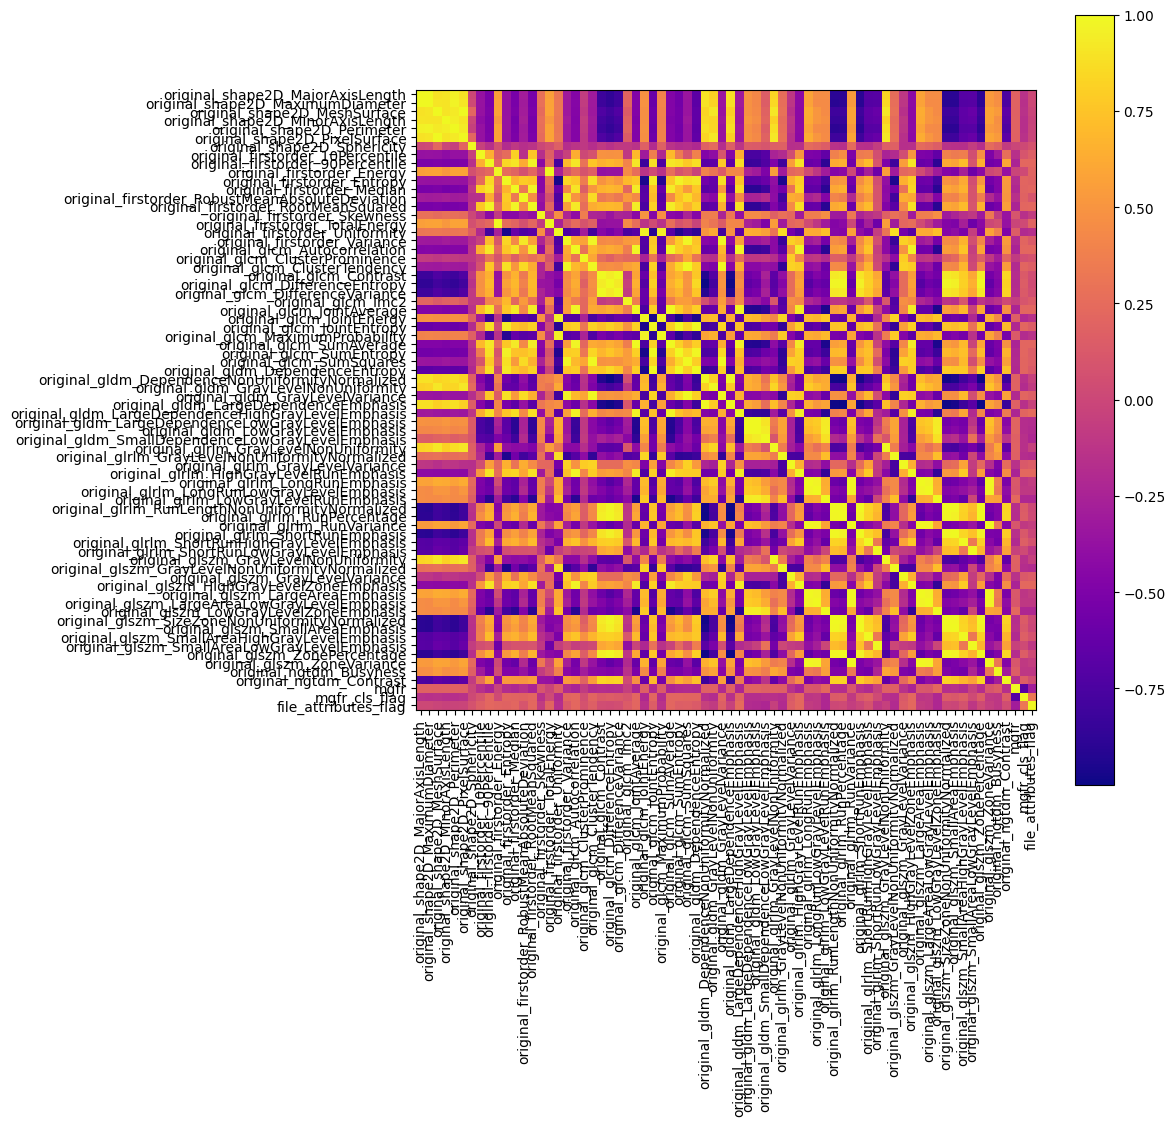

In [7]:
# plotting correlation ratios for visualization:
corrMatrix= data_processed_no_id.corr()
print('Correlation Heatmap')
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(corrMatrix, cmap='plasma')
ax.set_xticks(np.arange(len(corrMatrix)))
ax.set_yticks(np.arange(len(corrMatrix)))
ax.set_xticklabels(corrMatrix.columns)
ax.set_yticklabels(corrMatrix.columns)
plt.xticks(rotation='vertical')
plt.colorbar(im)
plt.savefig('corrMatrix.png')
corrMatrix.to_csv('corrMatrix.csv', index = False)


# Machine Learning Section

In [8]:
#SKlearn models
#arguments are compilation of all possible hyperparams
def fit_model(xTrain,yTrain, xTest, yTest, model_name, max_depth_RF = 5, min_samples = 5,
          min_split = 5, num_trees = 20, n_sample =100, max_iter = 500, 
            kernel = 'linear', max_depth_DT = 4, 
            iter_cb = 100, lr_cb = 0.2, random_state = 42):
    
    if(model_name == "RF"):
        model = RandomForestClassifier(class_weight='balanced', n_jobs = -1,
                                   warm_start = True, max_depth = max_depth_RF, 
                                   min_samples_leaf = min_samples,
                                   min_samples_split = min_split, 
                                   n_estimators = num_trees)
        model.fit(xTrain, yTrain) 
        imps = model.feature_importances_
        
    elif(model_name == "SVM"):
        model = svm.SVC(kernel = kernel, probability= True, decision_function_shape = 'ovr')
        model.fit(xTrain, yTrain) 
        # perform permutation importance
        imps_temp = permutation_importance(model, xTrain, yTrain, 
                                      scoring='neg_mean_squared_error')
        # get importance
        imps = imps_temp.importances_mean

    elif(model_name == "NN"):
        model = MLPClassifier(random_state=random_state, max_iter=max_iter)
        #there is no inherent feature importance algorithm for a NN
        (row,col) = xTrain.shape
        model.fit(xTrain, yTrain) 
        imps = np.zeros(col)
        
    elif(model_name == "DT"):
        model = DecisionTreeClassifier(max_depth=max_depth_DT,random_state=0)
        #for some reason the DT classifier needs to be fitted before
        #extracting feature importances
        model.fit(xTrain, yTrain)
        imps = model.feature_importances_
        feature_names = xTrain.columns
        graph = Source(export_graphviz(model, out_file='tree.dot', 
                                       class_names=['Normal','Indeterminate','Grade II', 'Grade III'], 
                                       feature_names=feature_names, impurity=False, filled=True))
    elif(model_name == "catboost"):
        model = CatBoostClassifier(iterations = 100,
                                 random_seed = 32,
                                 learning_rate = 0.5)
        #catboost has it's own weird fit function arguments
        model.fit(xTrain, yTrain, eval_set = (xTest, yTest), silent = True)
        preds = model.predict(xTest)
        imps = model.get_feature_importance(type='PredictionValuesChange', 
                                                prettified = False)    
        
    preds = model.predict(xTest)
    preds_proba = model.predict_proba(xTest)
    
    return model, preds, preds_proba, imps

    

In [9]:
def train_classifier(data_input, model_name = 'RF', outcome_name = "mgfr_cls_flag", k = 5,
                     all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'],
                     max_depth_RF = 5, min_samples = 5,
                    min_split = 5, num_trees = 20, n_sample =100, max_iter = 300, 
                    kernel = 'linear', max_depth_DT = 4, 
                    iter_cb = 100, lr_cb = 0.5, random_state = 42):
    
    sens = []
    spec = []
    acc = []
    # have to name auc aucVal beacuse auc is the library name
    auc_val = []
    imps_list = []
    i = 1
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6,3.75))
    
    outcome = data_input[outcome_name].astype(int)
    data_without_outcome = data_input.drop(columns=[col for col in all_outcome_labels if col in data_input.columns])

    
    kf=StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

    for trainIdx, testIdx in kf.split(data_without_outcome,outcome):
        print("Model: " + model_name + ", K-fold: " + str(i))
        xTrain, xTest = data_without_outcome.iloc[trainIdx], data_without_outcome.iloc[testIdx]
        yTrain, yTest = outcome.iloc[trainIdx], outcome.iloc[testIdx]
        #building model based on input

        model, preds, preds_proba, imp = fit_model(xTrain, yTrain, 
                                                  xTest, yTest, model_name, 
                                                   max_depth_DT = max_depth_DT)

        imps_list.append(imp)
        
        #appending to validation metrics for this k-fold
        cm = confusion_matrix(yTest, preds, labels = model.classes_)
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=model.classes_)
        #fig_cm, ax_cm = plt.subplots()
        #disp.plot(ax=ax_cm)
        #plt.show()
        #plt.close(fig_cm)
        
        #metrics
        tp = np.sum(np.diag(cm))
        fp = np.sum(cm.sum(axis=0)) - tp
        fn = np.sum(cm.sum(axis=1)) - tp
        tn = np.sum(cm.sum()) - (fp + fn + tp)

        spec.append(tn/(tn+fp))
        sens.append(tp/(tp+fn))
        acc.append((tp+tn)/(tp+tn+fp+fn))

        #computing and displaying AUC
        auc_val.append(roc_auc_score(yTest, preds))
        
        plt.figure(fig.number) 
        viz = RocCurveDisplay.from_estimator(model, xTest, yTest, 
                                             name="ROC fold {}".format(i), alpha=0.5, lw=1, ax=ax,)
    
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        i = i+1
        
    #plotting all AUCs
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,alpha=0.8,)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr,tprs_lower, tprs_upper,color="grey",
                    alpha=0.2,label=r"$\pm$ 1 std. dev.",)

    ax.set(xlim=[-0.05, 1.05],ylim=[-0.05, 1.05],)
    ax.legend(loc="lower right")
    plt.show()
        
    return sens, spec, acc, auc_val, imps_list, preds_proba

Model: catboost, K-fold: 1
Model: catboost, K-fold: 2
Model: catboost, K-fold: 3
Model: catboost, K-fold: 4
Model: catboost, K-fold: 5
Model: catboost, K-fold: 6
Model: catboost, K-fold: 7
Model: catboost, K-fold: 8
Model: catboost, K-fold: 9
Model: catboost, K-fold: 10


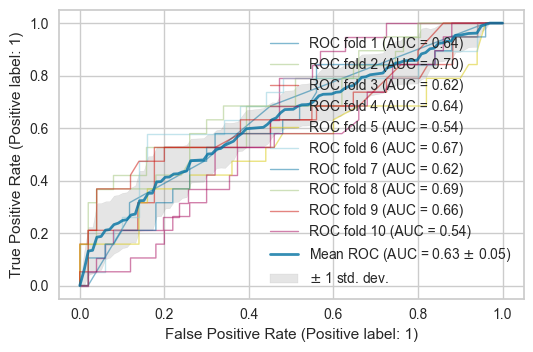

In [14]:
sens_RF, spec_RF, acc_RF, auc_val_RF, imps_RF, preds_proba_RF = train_classifier(data_processed_no_id,
                                                                                 model_name = 'catboost', 
                                                                                 outcome_name ="mgfr_cls_flag",
                                                                                 k = 10, max_depth_RF = 10, 
                                                                                 min_samples = 5, min_split = 5,
                                                                                 num_trees = 500,
                                                                                all_outcome_labels = ['file_attributes_flag', 'mgfr', 'mgfr_cls_flag'],)


In [13]:
from pycaret.classification import *
clf = setup(data=data_processed_no_id.drop(columns = ['file_attributes_flag', 'mgfr']), 
                                           target='mgfr_cls_flag')
best_model = compare_models()

,Description,Value
0,Session id,3996
1,Target,mgfr_cls_flag
2,Target type,Binary
3,Original data shape,"(694, 70)"
4,Transformed data shape,"(694, 70)"
5,Transformed train set shape,"(485, 70)"
6,Transformed test set shape,"(209, 70)"
7,Numeric features,69
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7258,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0060
catboost,CatBoost Classifier,0.7114,0.5940,0.0907,0.4850,0.1457,0.0490,0.0854,3.4600
rf,Random Forest Classifier,0.7095,0.5895,0.1516,0.4686,0.2191,0.0902,0.1171,0.0490
lr,Logistic Regression,0.7092,0.6126,0.0214,0.1833,0.0376,-0.0128,-0.0133,0.4720
et,Extra Trees Classifier,0.6929,0.5437,0.0984,0.4158,0.1431,0.0202,0.0454,0.0350
lda,Linear Discriminant Analysis,0.6927,0.5660,0.2478,0.4251,0.3027,0.1241,0.1370,0.0060
gbc,Gradient Boosting Classifier,0.6888,0.5763,0.1819,0.3857,0.2354,0.0732,0.0860,0.1290
lightgbm,Light Gradient Boosting Machine,0.6868,0.5882,0.1753,0.3592,0.2238,0.0653,0.0733,0.0800
ada,Ada Boost Classifier,0.6846,0.5603,0.1731,0.3669,0.2257,0.0609,0.0713,0.0400
ridge,Ridge Classifier,0.6682,0.0000,0.1363,0.2808,0.1671,0.0128,0.0194,0.0070
